### Seamless Bay Area Tweet Analysis: Part 2, Exploratory Data Analysis


The goal of this project is to analyze the twitter account of the nonprofit group Seamless Bay Area and determine what makes up the most high-impact tweet as measured by engagements.

In part two we perform some EDA to see what we're working with.

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import statistics as stat
import re
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [10]:
df = pd.read_csv("/Users/grahamsmith/Documents/SpringboardWork/Seamless_Twitter_Analysis/cleaned tweets.csv")

In [11]:
#once again, here is our data for reference
df.head()

Unnamed: 0                                         Tweet text  \
0           0  @MTCBATA is looking for a new Executive Direct...   
1           1     Ultimate seamlessness. https://t.co/CdCLrg2o6a   
2           2  Help Nix Prop 6! Save funding for more seamles...   
3           3  It doesn't have to be this way! Let's get to f...   
4           4  And then come say hi at next month’s @SPUR_Urb...   

                  time  impressions  engagements  engagement rate  retweets  \
0  2018-10-27 18:01:00        124.0          5.0         0.040323       0.0   
1  2018-10-26 14:24:00        345.0         10.0         0.028986       0.0   
2  2018-10-26 02:28:00        994.0         19.0         0.019115       4.0   
3  2018-10-23 23:29:00        792.0          7.0         0.008838       2.0   
4  2018-10-23 23:09:00        532.0          3.0         0.005639       0.0   

   replies  likes  user profile clicks  url clicks  \
0      0.0    0.0                  1.0         4.0   
1      0.0    1.0                  0.0         9.0   
2      0.0    5.0                  3.0         5.0   
3      0.0    4.0                  1.0         0.0   
4      0.0    1.0                  2.0         0.0   

                                         tweet words  
0  ['@mtcbata', 'is', 'looking', 'for', 'a', 'new...  
1  ['ultimate', 'seamlessness.', 'https://t.co/cd...  
2  ['help', 'nix', 'prop', 'save', 'funding', 'fo...  
3  ['it', "doesn't", 'have', 'to', 'be', 'this', ...  
4  ['and', 'then', 'come', 'say', 'hi', 'at', 'ne...

Let's start with the lowest hanging fruit by checking the linear relationship between some easy to engineer features and engagements.

In [14]:
#let's make hour and minute their own columns for the regression
#for some inexplicable reason, to_csv reverts datetime objects to strings so it needs to be converted again
from datetime import datetime
temp = []
for x in range(len(df['time'])):
    temp.append(datetime.strptime(str(df['time'].iloc[x]), '%Y-%m-%d %H:%M:%S'))
df['time'] = temp

temp = []
for x in df['time']:
    temp.append(x.hour)
df['hour'] = temp

temp = []
for x in df['time']:
    temp.append(x.minute)
df['minute'] = temp

Does minute or hour have any linear relationship with engagements?

In [16]:
#check the relationship between minute of the hour and engagements
model = LinearRegression()
a = df['minute'].to_numpy()
x = a.reshape(-1, 1)
y = df['engagements']
model.fit(x,y)
r_sq = model.score(x, y)
r_sq


0.0008656056383354871

Well that's pretty bad. Let's check the components of engagements (retweets, likes, user profile clicks, and url clicks to see if they are any better)

In [96]:
#check the relationship between minute of the hour and engagements
model = LinearRegression()
a = df['minute'].to_numpy()
x = a.reshape(-1, 1)
component_cols = df.columns[6:11]
for y in component_cols:
    z = df[str(y)]
    model.fit(x,z)
    r_sq = model.score(x, z)
    print(r_sq)


0.0018227199865947785
8.042008938502487e-05
0.001384725052739677
0.002011070623837319
0.0026260684731778117


Not much better. How about for hour?

In [90]:
#check the relationship between hour of the day and engagements
model = LinearRegression()
a = df['hour'].to_numpy()
x = a.reshape(-1, 1)
y = df['engagements']
model.fit(x,y)
r_sq = model.score(x, y)
r_sq


7.496145321439496e-05

In [97]:
#check the relationship between minute of the hour and engagements
model = LinearRegression()
a = df['hour'].to_numpy()
x = a.reshape(-1, 1)
component_cols = df.columns[6:11]
for y in component_cols:
    z = df[str(y)]
    model.fit(x,z)
    r_sq = model.score(x, z)
    print(r_sq)

0.000882945640148125
4.989128501442508e-06
0.00016091964504161282
2.2368825847163265e-06
0.0002579057132280349


Pretty much as bad as the others. What about tweet length?

In [107]:
# AVERAGE NUMBER OF WORDS
y = []
for x in df['tweet words']:
    y.append(len(x))
df['tweet length'] = y
#check the relationship between hour of the day and engagements
model = LinearRegression()
a = df['tweet length'].to_numpy()
x = a.reshape(-1, 1)
y = df['engagements']
model.fit(x,y)
r_sq = model.score(x, y)
print(r_sq)
component_cols = df.columns[6:11]
for y in component_cols:
    z = df[str(y)]
    model.fit(x,z)
    r_sq = model.score(x, z)
    print(r_sq)

0.007410389451631749
0.024437843470524023
0.0129464531461011
0.021177570921540045
0.010479325696019504
0.005121774293253334


Well, it's orders of magnitude less awful than datetime, but that's not saying much. Why don't we just see how our main target variable is distributed.

In [18]:
stat.stdev(df['engagements'])

202.7709727690056

In [19]:
np.mean(df['engagements'])

41.76567363272566

In [21]:
np.median(df['engagements'])

13.0

Alright, the median is considerably lower than the mean which implies that there are some large outliers.

In [20]:
np.max(df['engagements'])

6879.0

<AxesSubplot:>

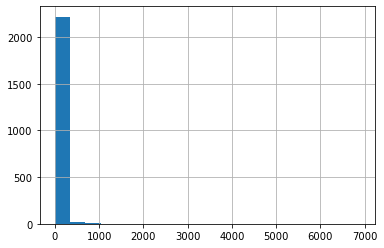

In [60]:
df['engagements'].hist(bins=20)

In [42]:
temp = []
for x in df['engagements']:
    if x > 42:
        temp.append(x)
len(temp)

444

only 20% of tweets are above the average number of engagements, which is extremely skewed on the low side. How skewed?

In [111]:
import scipy
scipy.stats.skew(df['engagements'])

24.85900650213547

oof. That's not great. But it does mean that there are some extreme outliers we can look at that might tell us something about what identifies a very successful tweet.

In [112]:
#Let's define "high value" tweets as those in the top 20%, with a number of engagements above average
hi_value = df[df['engagements']>42]

In [116]:
hi_value_eng = hi_value.sort_values(by=['engagements'], ascending=False)
hi_value_eng

Unnamed: 0                                         Tweet text  \
390           36  Today, Seamless Bay Area is unveiling a map of...   
2185          25  We created a map of the Bay Area's existing tr...   
2177          17  Clearly, our existing Bay Area transit system ...   
1839          23  It takes 11 minutes to walk between the new La...   
124           77  To be clear about what we do and don't advocat...   
...          ...                                                ...   
203           58  "With 27 transit agencies serving the region’s...   
282           18  60 minutes to get between any two rail station...   
1741          41  Congrats to our Seamless Bay Area Award winner...   
2047          47  The Bay Area's Blue Ribbon Transit Recovery Ta...   
501           67  ICYMI: Join us on Sept. 21 for a lively conver...   

                    time  impressions  engagements  engagement rate  retweets  \
390  2020-10-27 17:28:00      43436.0       6879.0         0.158371     156.0   
2185 2019-07-22 15:26:00      91437.0       5065.0         0.055393     169.0   
2177 2019-07-23 14:00:00      18923.0       2118.0         0.111927      56.0   
1839 2020-01-04 18:29:00      33552.0       1549.0         0.046167      99.0   
124  2020-12-06 21:40:00      13346.0       1035.0         0.077551      15.0   
...                  ...          ...          ...              ...       ...   
203  2020-07-06 17:34:00       3692.0         43.0         0.011647       8.0   
282  2019-06-10 18:18:00       1722.0         43.0         0.024971       2.0   
1741 2019-09-14 03:46:00       1122.0         43.0         0.038324       3.0   
2047 2020-09-08 15:26:00       3042.0         43.0         0.014135       5.0   
501  2021-09-02 22:15:00       1536.0         43.0         0.027995       2.0   

      replies  likes  user profile clicks  url clicks  \
390      11.0  357.0                159.0       614.0   
2185     17.0  389.0                302.0        85.0   
2177     10.0  140.0                 53.0       263.0   
1839     14.0  283.0                207.0         5.0   
124       2.0  103.0                 54.0         0.0   
...       ...    ...                  ...         ...   
203       0.0   18.0                  5.0         0.0   
282       1.0    7.0                  2.0        24.0   
1741      0.0    7.0                  5.0         1.0   
2047      0.0    9.0                  4.0        12.0   
501       1.0    7.0                  3.0         9.0   

                                            tweet words  hour  minute  \
390   ['today,', 'seamless', 'bay', 'area', 'is', 'u...    17      28   
2185  ['we', 'created', 'a', 'map', 'of', 'the', 'ba...    15      26   
2177  ['clearly,', 'our', 'existing', 'bay', 'area',...    14       0   
1839  ['it', 'takes', 'minutes', 'to', 'walk', 'betw...    18      29   
124   ['to', 'be', 'clear', 'about', 'what', 'we', '...    21      40   
...                                                 ...   ...     ...   
203   ['"with', 'transit', 'agencies', 'serving', 't...    17      34   
282   ['minutes', 'to', 'get', 'between', 'any', 'tw...    18      18   
1741  ['congrats', 'to', 'our', 'seamless', 'bay', '...     3      46   
2047  ['the', 'bay', "area's", 'blue', 'ribbon', 'tr...    15      26   
501   ['icymi:', 'join', 'us', 'on', 'sept.', 'for',...    22      15   

                                                    ats  tweet length  
390                                                  []           423  
2185                                                 []           313  
2177  [@seamlessbayarea Vision Map in partnership w,...           411  
1839   [@smarttrain station and the , @GoldenGateFerry]           420  
124                                                  []           406  
...                                                 ...           ...  
203   [@CityLab piece about about the movement towar...           390  
282                                       

Okay, so engagements drops off super fast. Let's take a look at the tweet content for the top 10.

In [121]:
for x in hi_value_eng['Tweet text'][0:20]:
    print(x)

Today, Seamless Bay Area is unveiling a map of our Integrated Transit Fare Vision — a fully unified system of transit fares that would enable riders to travel seamlessly across the nine-county Bay Area with a single transit fare and free transfers 🗺️ https://t.co/P94GGBfgVV https://t.co/J1Yh89BzE4
We created a map of the Bay Area's existing transit agencies' service areas, each of which have separate fares, schedules, route planning, and branding.

We think the problem speaks for itself. https://t.co/pOVU6i95cU
Clearly, our existing Bay Area transit system doesn't work, and riders deserve better. 

So what would a seamless, unified system look like? We just published our @seamlessbayarea Vision Map in partnership w/ @interline_io to illustrate just that.

https://t.co/LaszH9qvDk https://t.co/0OB8Ds2lNc
It takes 11 minutes to walk between the new Larkspur @smarttrain station and the @GoldenGateFerry. The fastest way, shown here, involves cutting through a parking lot and crossing 4 stre

Finally! We have something interesting. The top 20 tweets all have several things in common just from a visual inspection. Nearly all feature original videos, pictures, and especially maps (the top 3 all have maps). Several have some kind of calls to action (polls, upcoming bills, or crowdfunding). We can definitely explore this in the next notebook.

I'm curious as to whether some features of engagement might be varying more significantly than other. To find out, I normalized each of the columns via maximum absolute scaling so that each value is between -1 and 1 to make direct comparison more legible.

In [150]:
stat.stdev(hi_value['retweets'] /hi_value['retweets'].abs().max())

0.07695686008030066

In [155]:
stat.stdev(hi_value['likes'] /hi_value['likes'].abs().max())

0.08795445125564791

In [152]:
stat.stdev(hi_value['replies'] /hi_value['replies'].abs().max())

0.10573012605634688

In [153]:
stat.stdev(hi_value['user profile clicks'] /hi_value['user profile clicks'].abs().max())

0.07216321519924375

In [154]:
stat.stdev(hi_value['url clicks'] /hi_value['url clicks'].abs().max())

0.06923034964668809

Darn, the standard deviations are pretty close to each other, not much to take away from that.

While not as informative as I'd hoped, since so many values are close to 0 and only a relatively small number of tweets had enough traction to provide usable data. In the next step of the project, pre-processing, I'm going to perform some more feature engineering and extract, at the very least, links, @replies, hashtags, and sentiment score from the tweets to prepare for modeling.